In [22]:
import gym
from gym import spaces
import numpy as np

class BanditEnv(gym.Env):
    """
    Non-stationary K-armed bandit with truncated Gaussian rewards in [0, 1].
    The mean of each arm evolves over time (non-stationary), and rewards are clipped to [0, 1].
    """

    def __init__(self, n_arms=10, seed=None, drift_scale=0.01, reward_std=0.01):
        super(BanditEnv, self).__init__()
        self.n_arms = n_arms
        self.rng = np.random.default_rng(seed)
        self.drift_scale = drift_scale
        self.reward_std = reward_std

        self.action_space = spaces.Discrete(n_arms)
        self.observation_space = spaces.Discrete(1)

        # Initialize the means in [0.25, 0.75] to avoid clipping too often
        self.means = self.rng.uniform(0.25, 0.75, size=n_arms)
        self.t = 0
        self.best_arm = int(np.argmax(self.means))

    def reset(self):
        self.t = 0
        return 0

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action"
        self.t += 1

        # Sample from a Gaussian and clip to [0, 1]
        reward = self.rng.normal(self.means[action], self.reward_std)
        reward = np.clip(reward, 0.0, 1.0)

        # Drift the means (simulate non-stationarity)
        self._drift_means()

        # Update best arm
        self.best_arm = int(np.argmax(self.means))

        done = False
        info = {
            "step": self.t,
            "expected_reward": self.means[action],
            "best_arm": self.best_arm,
            "best_expected_reward": self.means[self.best_arm],
            "optimal": (action == self.best_arm)
        }

        return 0, reward, done, info

    def _drift_means(self):
        # Add small Gaussian noise to simulate non-stationarity
        self.means += self.rng.normal(0, self.drift_scale, size=self.n_arms)
        self.means = np.clip(self.means, 0.0, 1.0)

    def render(self, mode="human"):
        print(f"Step {self.t} | Means: {np.round(self.means, 3)} | Best arm: {self.best_arm}")

    def seed(self, seed=None):
        self.rng = np.random.default_rng(seed)


In [23]:
class Exp3():
    """ Design Exp3 agent for stochastic environments """
    def __init__(self, K):
        self.K = K 
        self.reset()

    def reset(self):
        self.t = 0 
        self.eps = 1 / self.K
        self.R = np.zeros(self.K)
        self.w = np.zeros(self.K)

    def draw_action(self):
        self.t += 1
        t = self.t
        K = self.K
        eps_t = min(1 / K, np.sqrt(np.log(K) / (K * t)))
        num = np.exp(- self.eps * self.R)
        self.w = (1 - eps_t * K) * (num / np.sum(num)) + eps_t
        self.eps = eps_t
        action = np.random.choice(range(K), p=self.w)
        self.index_action_chosen = action
        return action 
    
    def observe_reward(self, r):
        self.R[self.index_action_chosen] += r / self.w[self.index_action_chosen]

    def name(self):
        return 'Exp3'
        

In [24]:
import seaborn as sns 
from tqdm import tqdm
colors = sns.color_palette('colorblind')
import matplotlib.pyplot as plt

def experiment(environment, agents, Nmc, T):
    all_data = {}
    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)
        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

def play(environment, agent, Nmc, T):
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))

    for episode in tqdm(range(Nmc)):
        environment.reset()
        agent.reset()   
        
        for t in range(T):
            index_action = agent.draw_action()
            _, r, _, info = environment.step(index_action)
            agent.observe_reward(r)

            # Compute pseudo-regret: 
            data[episode, t] = info["best_expected_reward"] - info["expected_reward"] 
    return agent.name(), data


def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None, UCB_regret=False):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()

100%|██████████| 10/10 [00:00<00:00, 29.65it/s]
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_47446/198573462.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


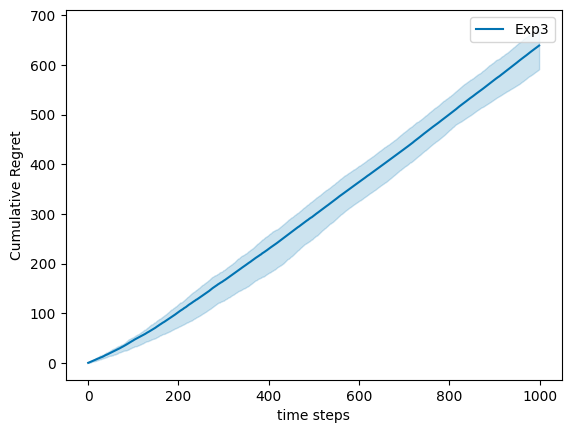

In [25]:
env = BanditEnv(n_arms=10, seed=None)
agent = Exp3(K=10)

regrets = experiment(environment=env, agents=[agent], Nmc=10, T=1000)
plot_regret(regrets)